In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc,
    get_acc_EfficentNet, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint,
    plot_keypoints_IoU)

from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)
import matplotlib.patches as patches

from Keypoint_dataset import Keypoint_dataset
from torch.optim.lr_scheduler import StepLR
from models_2 import KeypointModel, EfficentNet, UNET

In [6]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(42)
torch.manual_seed(42)

In [7]:
from Keypoint_dataset_gaussian import get_loader_keypoint_simulated
train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(BATCH_SIZE=1)

keypoint_model = KeypointModel().to(device=DEVICE)
load_checkpoint(keypoint_model, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_gaussian_1.pth.tar')
EfficentNet = EfficentNet().to(DEVICE)
load_checkpoint(EfficentNet, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_gaussian_5.pth.tar')


=> Loading checkpoint
=> Loading checkpoint


In [8]:
def plot_keypoints_overreach_underreach(model, image, kp, tolerance, number_of_channels):
    '''
    image: (B, C, 256, 256)
    kp:  torch.Size([B, 8]))
    pred_kp: torch.Size([B, 8])
    '''
    if number_of_channels == 1:
        img = image.to(device = DEVICE)
    else:
        img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
    #kp = kp.to(DEVICE)
    pred_kp = model(img)

    boxes = []
    pred_kp = pred_kp.cpu().detach().numpy().astype(np.uint8)
    kp = kp.detach().numpy().astype(np.uint8)
    kp = kp[0]
    for keypoints in [kp, pred_kp]:
        keypoint_image = torch.zeros(image[0,0].shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1
        boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))
    test_box, pred_box = boxes[0][0], boxes[1][0]

    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = test_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

        # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Calculate union area
    union_area = pred_area + gt_area - intersection_area
    
    # IoU calculation
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / pred_area if pred_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    axs.imshow(image[0,0], cmap ='gray')
    for i in range(0,8,2):
        axs.scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'orange')
        axs.scatter(kp[0,i],kp[0,i+1], color = 'w')

    axs.axis('off')
    rect_pred = patches.Rectangle((x1_pred, y1_pred), x2_pred - x1_pred,
                                  y2_pred - y1_pred, linewidth=4, edgecolor='orange', facecolor='none', label='predicted crop with tolerance')
    rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='w', facecolor='none', label='true crop')

    #pred_rect_copy = copy(rect_pred)
    axs.add_patch(rect_pred)
    axs.add_patch(rect_test)
    box_iou = generalized_box_iou(boxes[0], boxes[1])
    box_iou = torch.nan_to_num(box_iou, 0)
    box_iou = torch.trace(box_iou)
    #plt.title(f"Overreach: {overreach:.3f}, Underreach: {underreach:.3f}", fontsize=15)
    plt.legend()
    plt.show()

In [9]:
def calculate_overreach_underreach(model, image, kp, tolerance, number_of_channels, device = DEVICE):
    '''
    image: (B, C, 256, 256)
    kp:  torch.Size([B, 8]))
    pred_kp: torch.Size([B, 8])
    '''
    if number_of_channels == 1:
        img = image.to(device)
    else:
        img = image.to(device).repeat(1, 3, 1, 1)
    #kp = kp.to(device)
    pred_kp = model(img)

    boxes = []
    pred_kp = pred_kp.cpu().detach().numpy().astype(np.uint8)
    kp = kp.detach().numpy().astype(np.uint8)
    kp = kp[0]
    for keypoints in [kp, pred_kp]:
        keypoint_image = torch.zeros(image[0,0].shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1
        boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))
    test_box, pred_box = boxes[0][0], boxes[1][0]

    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = test_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

        # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Calculate union area
    union_area = pred_area + gt_area - intersection_area
    
    # IoU calculation
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / pred_area if pred_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0

    return overreach, underreach

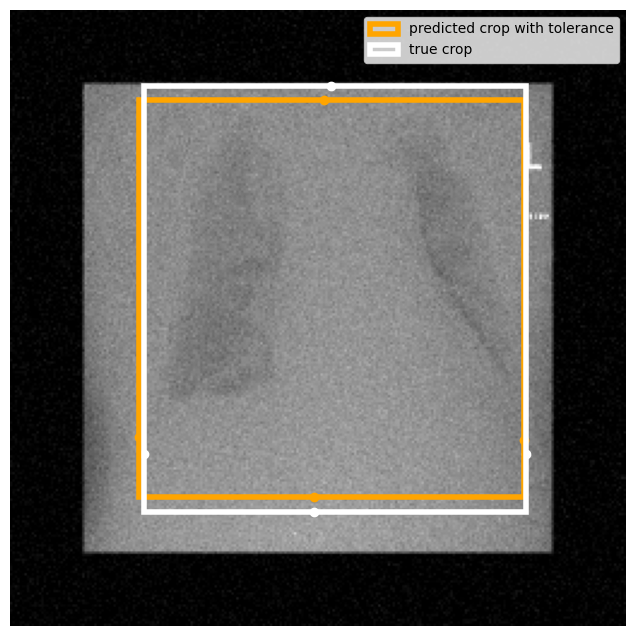

In [10]:
number_of_channels = 3
tolerance = 0

model = EfficentNet

for image, kp in test_loader:
    plot_keypoints_overreach_underreach(model, image, kp, tolerance, number_of_channels)
    break

In [18]:
overreachs, underreachs = [], []
tolerance = 10
for image, mask in test_loader:
    overreach, underreach = calculate_overreach_underreach(model, image, mask, tolerance, number_of_channels)
    overreachs.append(overreach)
    underreachs.append(underreach)
overreachs = 100* np.array(overreachs)
underreachs = 100*np.array(underreachs)

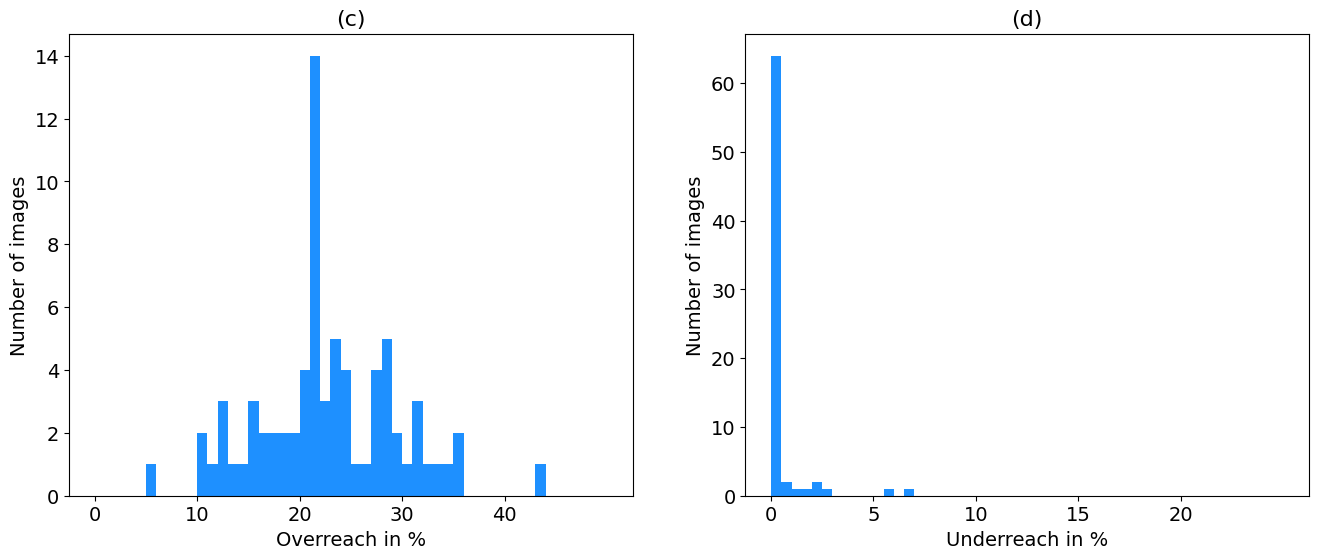

In [19]:


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(overreachs, bins = 50, color = 'dodgerblue', range = (0, 50))#, range = (0, 0.5))
axs[0].set_title('(c)', size = 16)
axs[0].set_xlabel('Overreach in %', size = 14)
axs[0].set_ylabel('Number of images', size = 14)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_xticks(np.arange(0, 50, step= 10))
axs[1].hist(underreachs, bins = 50, color = 'dodgerblue', range = (0, 25))#, range = (0, 0.5))
axs[1].set_title('(d)', size = 16)
axs[1].set_xlabel('Underreach in %', size = 14)
axs[1].set_ylabel('Number of images', size = 14)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_xticks(np.arange(0, 25, step= 5))
#fig.suptitle(f"EfficientNet_0 gaussian, tolerance = {tolerance}", fontsize=15)
#plt.savefig(r'/home/alex/Documents/Images_thesis/EffNet_overreach_underreach_with_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()



In [20]:
overreachs, underreachs = [], []
tolerance = 0
for image, mask in test_loader:
    overreach, underreach = calculate_overreach_underreach(model, image, mask, tolerance, number_of_channels)
    overreachs.append(overreach)
    underreachs.append(underreach)
overreachs = 100* np.array(overreachs)
underreachs = 100*np.array(underreachs)

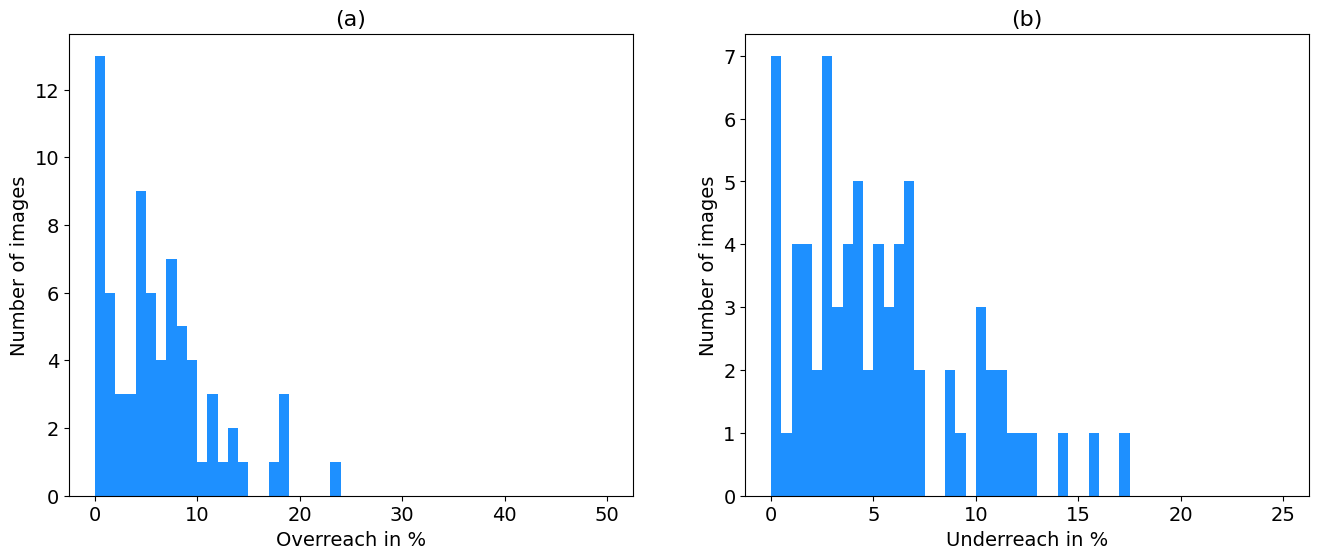

In [21]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(overreachs, bins = 50, color = 'dodgerblue', range = (0, 50))#, range = (0, 0.5))
axs[0].set_title('(a)', size = 16)
axs[0].set_xlabel('Overreach in %', size = 14)
axs[0].set_ylabel('Number of images', size = 14)
axs[0].tick_params(axis='both', labelsize=14)
#axs[0].xticks(np.arange(0, 50, step= 10))
axs[1].hist(underreachs, bins = 50, color = 'dodgerblue', range = (0, 25))#, range = (0, 0.5))
axs[1].set_title('(b)', size = 16)
axs[1].set_xlabel('Underreach in %', size = 14)
axs[1].set_ylabel('Number of images', size = 14)
axs[1].tick_params(axis='both', labelsize=14)
#axs[1].xticks(np.arange(0, 25, step= 5))
#fig.suptitle(f"EfficientNet_0 gaussian, tolerance = {tolerance}", fontsize=15)
plt.savefig(r'/home/alex/Documents/Images_thesis/EffNet_overreach_underreach_without_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()

In [ ]:
for image, kp in test_loader:
    plot_keypoints_overreach_underreach(model, image, kp, tolerance, number_of_channels)

In [28]:
train_loader, test_loader, validation_loader = get_loader_keypoint(BATCH_SIZE=1)



In [30]:
def plot_keypoints_overreach_underreach(model, image, kp, tolerance, number_of_channels):
    '''
    image: (B, C, 256, 256)
    kp:  torch.Size([B, 8]))
    pred_kp: torch.Size([B, 8])
    '''
    if number_of_channels == 1:
        img = image.to(device = DEVICE)
    else:
        img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
    #kp = kp.to(DEVICE)
    pred_kp = model(img)

    boxes = []
    pred_kp = pred_kp.cpu().detach().numpy().astype(np.uint8)
    kp = kp.detach().numpy().astype(np.uint8)
    kp = kp[0]
    for keypoints in [kp, pred_kp]:
        keypoint_image = torch.zeros(image[0,0].shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1
        boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))
    test_box, pred_box = boxes[0][0], boxes[1][0]

    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = test_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

        # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Calculate union area
    union_area = pred_area + gt_area - intersection_area
    
    # IoU calculation
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    axs.imshow(image[0,0], cmap ='gray')
    for i in range(0,8,2):
        axs.scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'orange')
        axs.scatter(kp[0,i],kp[0,i+1], color = 'w')

    plt.title(f"Tolerance: {tolerance}, Overreach: {overreach:.3f}, Underreach: {underreach:.3f}", fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
for image, kp in test_loader:
    plot_keypoints_overreach_underreach(model, image, kp, tolerance, number_of_channels)